# Testing the augmentation class 


In [ ]:
import tensorflow as tf

path = "/home/tfuser/project/Satelite/dataset/train"

In [125]:
import geopandas as gpd

path ="/home/tfuser/project/Satelite/data/parcels/AG_parcel_10.gpkg"
fil33 = gpd.read_file(path)
fil33.head()

# Iterate over the rows of the GeoDataFrame and calculate the area of each 
# Check if there are any multipolygons
for index, row in fil33.iterrows():
    if row['geometry'].geom_type == 'MultiPolygon':
        print('MultiPolygon at index {0}'.format(index))
    else:
        print('No MultiPolygon at index {0}'.format(index))
        

No MultiPolygon at index 0
No MultiPolygon at index 1
No MultiPolygon at index 2
No MultiPolygon at index 3
No MultiPolygon at index 4
No MultiPolygon at index 5
No MultiPolygon at index 6
No MultiPolygon at index 7
No MultiPolygon at index 8
No MultiPolygon at index 9
No MultiPolygon at index 10
No MultiPolygon at index 11
No MultiPolygon at index 12
No MultiPolygon at index 13
No MultiPolygon at index 14
No MultiPolygon at index 15
No MultiPolygon at index 16
No MultiPolygon at index 17
No MultiPolygon at index 18
No MultiPolygon at index 19
No MultiPolygon at index 20
No MultiPolygon at index 21
No MultiPolygon at index 22
No MultiPolygon at index 23
No MultiPolygon at index 24
No MultiPolygon at index 25
No MultiPolygon at index 26
No MultiPolygon at index 27
No MultiPolygon at index 28
No MultiPolygon at index 29
No MultiPolygon at index 30
No MultiPolygon at index 31
No MultiPolygon at index 32
No MultiPolygon at index 33
No MultiPolygon at index 34
No MultiPolygon at index 35
No

In [88]:
"""
Extracts the parcels from the main data and adjusts them according to 
the satelite image. 
"""
import geopandas as gpd
import rasterio
from shapely.geometry import box

# Load the cantonal data: 
canton = "/home/tfuser/project/Satelite/data/AG.gpkg"
canton = gpd.read_file(canton)




In [113]:
import rasterio
from rasterio.features import shapes
import numpy as np
from shapely.geometry import shape, box
import geopandas as gpd

import rasterio
import geopandas as gpd
from rasterio.features import shapes
import numpy as np

def get_data_mask(image_path):
    """
    Extracts the data mask from a satellite image and converts it to a GeoDataFrame.
    Only the largest area with data is included, based on the non-null data values in the image.
    """
    with rasterio.open(image_path) as src:
        if src.nodata is not None:
            # Create a mask where 1 indicates data is present and 0 indicates no data
            mask = src.read_masks(1) != 0
        
        # Generate polygons from the data mask
        mask_shapes = shapes(mask.astype(np.uint8), mask=mask, transform=src.transform)
        
        # Create GeoDataFrame from polygons where data is present
        gdf = gpd.GeoDataFrame.from_features(
            [{"geometry": shape, "properties": {}} for shape, value in mask_shapes if value == 1],
            crs=src.crs
        )
        
        # Filter to only keep the largest polygon by area
        if not gdf.empty:
            gdf['area'] = gdf['geometry'].area
            largest_polygon = gdf.loc[gdf['area'].idxmax()]
            return gpd.GeoDataFrame([largest_polygon], crs=src.crs)
        
        return gdf 
    
def get_image_extent_with_mask(image_path):
    """Extract the image extent and no-data mask."""
    with rasterio.open(image_path) as img:
        bounds = img.bounds
        meta = img.meta.copy()
        mask = get_data_mask(image_path)
        return box(bounds.left, bounds.bottom, bounds.right, bounds.top), meta, mask

def trim_parcels_to_data_areas(canton, image_extent, crs, data_mask_gdf):
    """Trim parcels to only include the areas that overlap with data-rich regions of the satellite image."""
    
    # Intersect with image extent with spatial join:
    image_extent_gdf = gpd.GeoDataFrame([{'geometry': image_extent}], crs=crs)
    trimmed_parcels = gpd.sjoin(canton, image_extent_gdf, how='inner', op='intersects')

    # Intersect with data areas
    trimmed_parcels = gpd.overlay(trimmed_parcels, data_mask_gdf, how='intersection')

    return trimmed_parcels


if __name__ == "__main__":
    satellite_image = "/home/tfuser/project/Satelite/data/satellite/AG_parcel_163.tif"
    image_extent, meta, data_mask_gdf = get_image_extent_with_mask(satellite_image)
    canton = canton.to_crs(meta['crs'])  
    trimmed = trim_parcels_to_data_areas(canton, image_extent, meta['crs'], data_mask_gdf)
    trimmed.to_file("trimmed.gpkg", driver="GPKG")



/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
"""
This script loads the tensorflow dataset and does on the fly augmentation 
during the training process. 
"""
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from pathlib import Path
import numpy as np

class LoadandAugment:
    
    def __init__(self, dataset, train=0.8, test=0.1, val=0.1, batch=30):
        self.dataset = tf.data.Dataset.load(dataset)
        self.train = train
        self.test = test
        self.val = val
        self.batch = batch
        self.train_set = None
        self.val_set = None
        self.test_set = None
        self.setup_datasets()
        
        
    # Augmentation functions:
    def add_random_brightness(self, image):
        """
        Randomly change the brightness of the image
        """
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image
    
    def add_horizontal_flip(self, image, mask):
        """
        Flip image horizontally
        """
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        return image, mask
    
    def add_rotation(self, image, mask):
        """
        Rotate image by +- 90 degrees
        """
        rotation = [+1, -1]
        random_rotation = np.random.choice(rotation)
        image = tf.image.rot90(image, k=random_rotation)
        mask = tf.image.rot90(mask, k=random_rotation)
        return image, mask

    def add_gaussian_blur(self, image):
        """
        Apply gaussian blur to an already normalized image using scipy. 
        The function expects a tensorflow tensor and returns a blurred version of the image. 
        Each band is blurred independently to maintain spectral integrity.
        """
        def _apply_blur(image):
            # Define the standard deviation for the Gaussian Kernel: (Higher values will increase the blur)
            sigma = np.random.uniform(0.5, 1.5)
            blurred_image = np.zeros_like(image)
            for i in range(4):
                blurred_image[:, :, i] = gaussian_filter(image[:, :, i], sigma=sigma)
            return blurred_image.astype(np.float32)
        
        blurred_image = tf.numpy_function(_apply_blur, [image], tf.float32)
        blurred_image.set_shape([1024, 1024, 4])
        return blurred_image
    
    def add_speckle_noise(self, image):
        """Apply speckle noise to an already normalized image."""
        speckle_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=1.0, stddev=tf.sqrt(speckle_variance))
        noisy_image = image * noise
        return noisy_image

    def add_gaussian_noise(self, image):
        """Apply gaussian noise to an already normalized image."""
        noise_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=tf.sqrt(noise_variance))
        noisy_image = image + noise
        return noisy_image

    def add_salt_and_pepper_noise(self, image):
        """
        Adds salt and pepper noise to an already normalized image.
        """
        noise_level = np.random.uniform(0.01, 0.1)
        shape = tf.shape(image)
        # Creates a tensors with the same size as the image with random values between 0 and 1:
        random_tensor = tf.random.uniform(shape, minval=0, maxval=1.0)

        # Creates a salt mask (white pixels) i.e. at 6% noise_level => 3% of the pixels will be white
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be white
        salt_mask = tf.cast(random_tensor <= (noise_level / 2), image.dtype)
        # Creates a pepper mask (black pixels) i.e. at 6% noise_level => 3% of the pixels will be black
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be black
        pepper_mask = tf.cast(random_tensor >= (1 - noise_level / 2), image.dtype)
        # Apply the masks to the image
        image_with_salt = tf.where(salt_mask == 1, tf.ones_like(image), image)
        noisy_image = tf.where(pepper_mask == 1, tf.zeros_like(image), image_with_salt)

        return noisy_image   
    
    def augment(self, image, mask):
        
        # Adds a horizontal flip to the image and mask with a 50% probability
        if np.random.rand() > 0.5:
            image, mask = self.add_horizontal_flip(image, mask)
    
        # Adds a rotation to the image and mask with a 20% probability
        if np.random.rand() < 0.2:
            image, mask = self.add_rotation(image, mask)
    
        # Adds one of the following noises/blurs with a 50 % probability (Gaussian, speckle, salt and pepper, gaussian noise)
        if np.random.rand() > 0.5:
            noise_functions = [self.add_gaussian_noise, self.add_speckle_noise, self.add_salt_and_pepper_noise, self.add_gaussian_blur, self.add_random_brightness]
            noise_function = np.random.choice(noise_functions)
            image = noise_function(image)
        
        return image, mask
         
    def load_and_augment(self):
        
        # Calculate the number of examples in each split
        dataset_size = len(list(self.dataset))
        train_size = int(self.train * dataset_size)
        val_size = int(self.val * dataset_size)
                
        # Shuffle the dataset
        self.dataset = self.dataset.shuffle(1000)
        
        # Split the dataset into training, validation, and testing
        self.train_set = self.dataset.take(train_size)
        remaining = self.dataset.skip(train_size)
        self.val_set = remaining.take(val_size)
        self.test_set = remaining.skip(val_size) 
        
        # Map the training dataset with augmentation
        self.train_set = self.train_set.map(self.augment).batch(self.batch).prefetch(1)
        self.val_set = self.val_set.batch(self.batch).prefetch(1)
        self.test_set = self.test_set.batch(self.batch).prefetch(1)
        
        return self.train_set, self.val_set, self.test_set
        
        

In [76]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from pathlib import Path
import numpy as np
import rasterio


class CreateTensorflowDataset:
    """
    This class prepares the tensorflow dataset for training:
    - Loads and processes the images and masks
    """

    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.base_path = self.data_path.parent
        self.satellite_dir = self.base_path / 'satellite'
        self.mask_dir = self.base_path / 'mask'

    def process_image(self, image_path):
        """
        Tensorflow function to process the satellite images for tensorflow datasets.
        :param image_path: A string of the image path
        :return: tensorflow compatible float32 image
        """

        def _load_image(path):
            with rasterio.open(path.decode("utf-8")) as src:
                image = src.read().transpose((1, 2, 0))
                return image.astype(np.float32)

        tensor = tf.numpy_function(_load_image, [image_path], tf.float32)
        tensor.set_shape([1024, 1024, 4])
        return tensor

    def process_mask(self, mask_path):
        """
        Tesnorflow function to process the masks for tensorflow datasets
        :param mask_path: A string of the mask path
        :return: tensorflow compatible uint8 image
        """

        def _load_mask(path):
            with rasterio.open(path.decode("utf-8")) as src:
                mask = src.read(1)
                mask = np.expand_dims(mask,
                                      -1)  # Adds a new dimension in the end of the array (height, width, channels=1)
                return mask.astype(np.uint8)

        tensor = tf.numpy_function(_load_mask, [mask_path], tf.uint8)
        tensor.set_shape([1024, 1024, 1])
        return tensor
    
    
    # Add the augmentation here:
    def add_horizontal_flip(self, image, mask):
        """
        Flip image horizontally
        """
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        return image, mask
    
    def add_rotation(self, image, mask):
        """
        Rotate image by +- 90 degrees
        """
        rotation = [+1, -1]
        random_rotation = np.random.choice(rotation)
        image = tf.image.rot90(image, k=random_rotation)
        mask = tf.image.rot90(mask, k=random_rotation)
        return image, mask

    def add_gaussian_blur(self, image):
        """
        Apply gaussian blur to an already normalized image using scipy. 
        The function expects a tensorflow tensor and returns a blurred version of the image. 
        Each band is blurred independently to maintain spectral integrity.
        """
        def _apply_blur(image):
            # Define the standard deviation for the Gaussian Kernel: (Higher values will increase the blur)
            sigma = np.random.uniform(0.5, 1.5)
            blurred_image = np.zeros_like(image)
            for i in range(4):
                blurred_image[:, :, i] = gaussian_filter(image[:, :, i], sigma=sigma)
            return blurred_image.astype(np.float32)
        
        blurred_image = tf.numpy_function(_apply_blur, [image], tf.float32)
        blurred_image.set_shape([1024, 1024, 4])
        return blurred_image
    
    def add_speckle_noise(self, image):
        """Apply speckle noise to an already normalized image."""
        speckle_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=1.0, stddev=tf.sqrt(speckle_variance))
        noisy_image = image * noise
        return noisy_image

    def add_gaussian_noise(self, image):
        """Apply gaussian noise to an already normalized image."""
        noise_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=tf.sqrt(noise_variance))
        noisy_image = image + noise
        return noisy_image

    def add_salt_and_pepper_noise(self, image):
        """
        Adds salt and pepper noise to an already normalized image.
        """
        noise_level = np.random.uniform(0.01, 0.1)
        shape = tf.shape(image)
        # Creates a tensors with the same size as the image with random values between 0 and 1:
        random_tensor = tf.random.uniform(shape, minval=0, maxval=1.0)

        # Creates a salt mask (white pixels) i.e. at 6% noise_level => 3% of the pixels will be white
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be white
        salt_mask = tf.cast(random_tensor <= (noise_level / 2), image.dtype)
        # Creates a pepper mask (black pixels) i.e. at 6% noise_level => 3% of the pixels will be black
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be black
        pepper_mask = tf.cast(random_tensor >= (1 - noise_level / 2), image.dtype)
        # Apply the masks to the image
        image_with_salt = tf.where(salt_mask == 1, tf.ones_like(image), image)
        noisy_image = tf.where(pepper_mask == 1, tf.zeros_like(image), image_with_salt)

        return noisy_image
    
    def augment(self, image, mask):
        
        # Adds a horizontal flip to the image and mask with a 50% probability
        if np.random.rand() > 0.5:
            image, mask = self.add_horizontal_flip(image, mask)
    
        # Adds a rotation to the image and mask with a 20% probability
        if np.random.rand() < 0.2:
            image, mask = self.add_rotation(image, mask)
    
        # Adds one of the following noises/blurs with a 50 % probability (Gaussian, speckle, salt and pepper, gaussian noise)
        if np.random.rand() > 0.5:
            noise_functions = [self.add_gaussian_noise, self.add_speckle_noise, self.add_salt_and_pepper_noise, self.add_gaussian_blur]
            noise_function = np.random.choice(noise_functions)
            image = noise_function(image)
        
        return image, mask
    
    def prepare_dataset(self):
        image_paths = sorted(self.satellite_dir.glob('*.tif'), key=lambda x: int(x.stem.split('_')[-1]))
        mask_paths = sorted(self.mask_dir.glob('*.tif'), key=lambda x: int(x.stem.replace('_mask', '').split('_')[-1]))
        image_paths = [str(path) for path in image_paths]
        mask_paths = [str(path) for path in mask_paths]
        
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(lambda x, y: (self.process_image(x), self.process_mask(y)),
                              num_parallel_calls=tf.data.AUTOTUNE)
        
        # Save the tensorflow dataset:
        save_path = self.base_path / 'dataset'
        if not save_path.exists():
            save_path.mkdir()
            
        tf.data.experimental.save(
            dataset, str(save_path), compression=None, shard_func=None, checkpoint_args=None
        )
        
        return dataset
        
        
        
        """
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(lambda x, y: (self.process_image(x), self.process_mask(y)),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset"""

    
 
            
    

(1024, 1024, 4) (1024, 1024, 1)


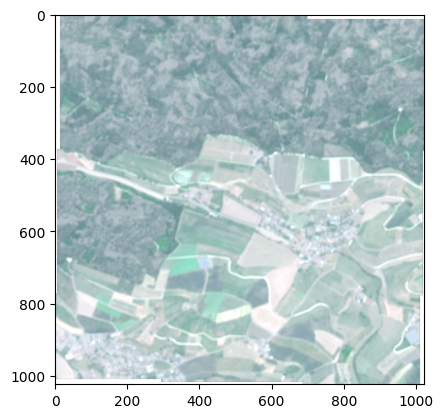

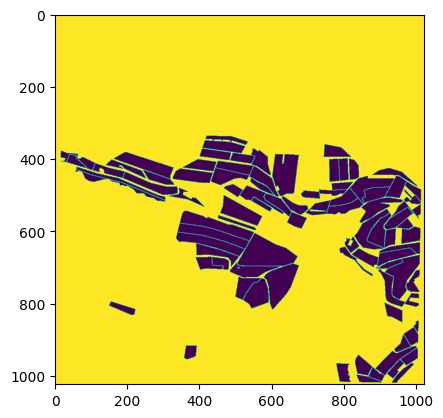

(1024, 1024, 4) (1024, 1024, 1)


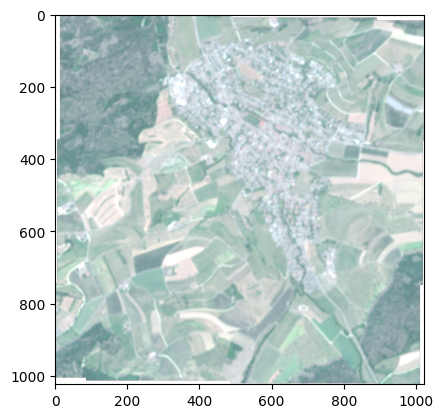

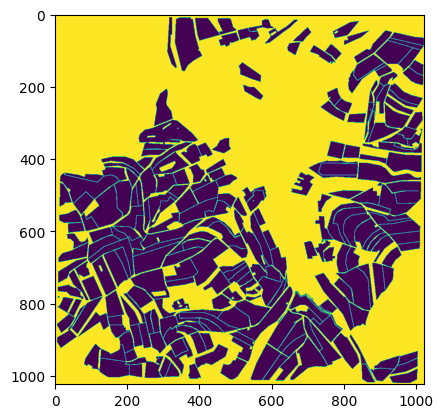

In [84]:
# Load the dataset:
import matplotlib.pyplot as plt
dataset = "/home/tfuser/project/Satelite/data/dataset"

dataset = tf.data.Dataset.load(dataset)
for image, mask in dataset.take(2):
    # Plot the image and mask
    print(image.shape, mask.shape)
    plt.figure()
    plt.imshow(image.numpy())
    plt.figure()
    plt.imshow(mask.numpy())
    plt.show()
    

In [78]:
data_dir = "./data/AG.gpkg"
loader = CreateTensorflowDataset(data_dir)
dataset = loader.prepare_dataset()


for image, mask in dataset.take(1):
    print("Final image shape:", image.shape)
    print("Final mask shape:", mask.shape)

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
Final image shape: (1024, 1024, 4)
Final mask shape: (1024, 1024, 1)


Final image shape: (1024, 1024, 4)
Final mask shape: (1024, 1024, 1)


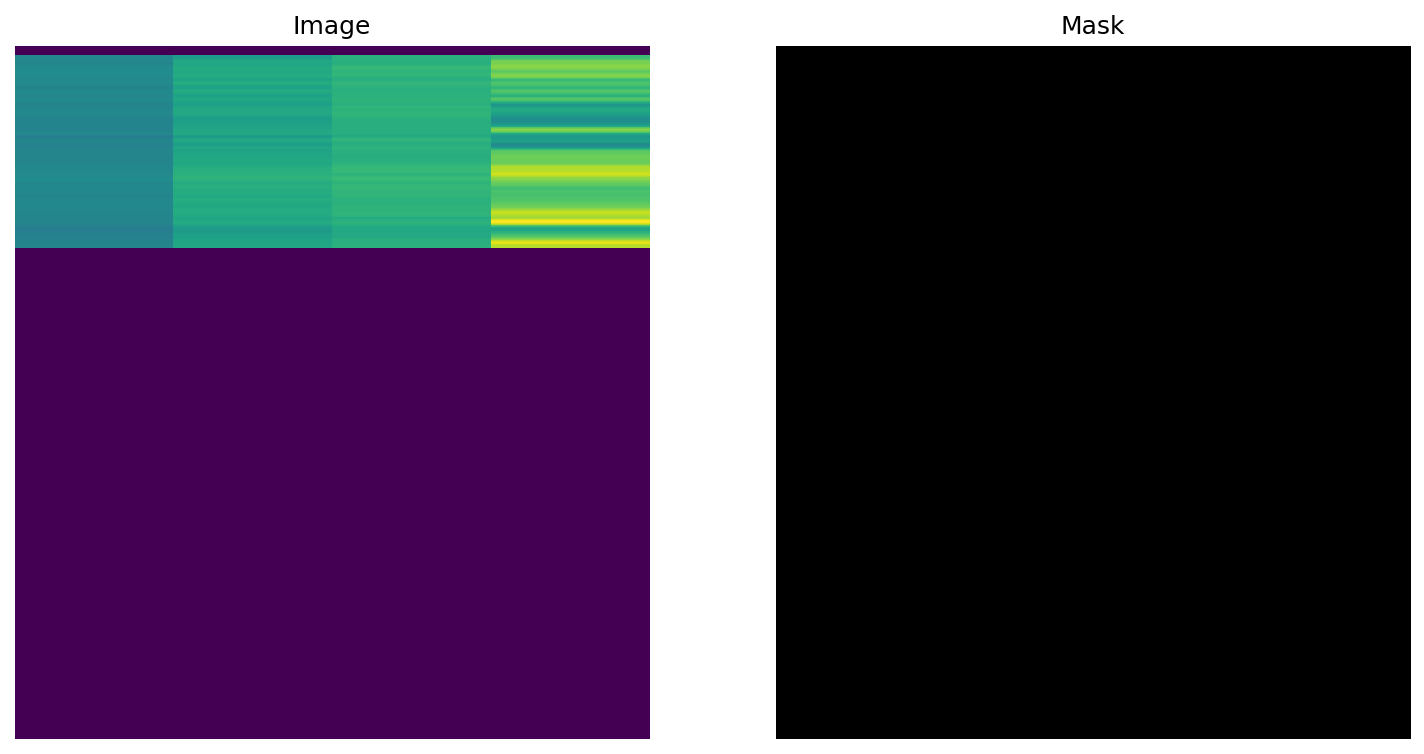

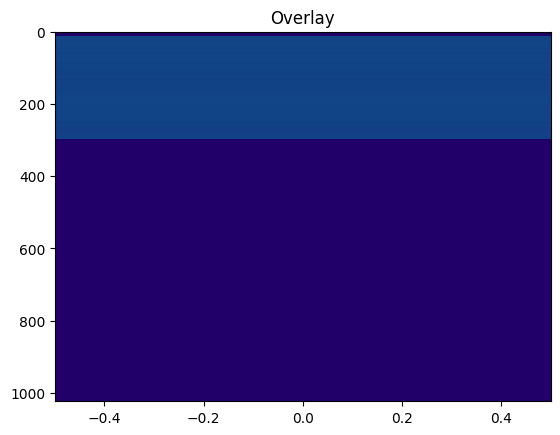

In [72]:
from matplotlib import pyplot as plt
for image, mask in dataset.take(1):
    print("Final image shape:", image.shape)
    print("Final mask shape:", mask.shape)
    image_np = image.numpy()  # Convert tensors to numpy arrays
    mask_np = mask.numpy()

    # Assuming image and mask are correctly shaped and scaled [0, 1] for visualization
    image_np = np.clip(image_np[0], 0, 1)  # Clip values to [0, 1] range and remove batch dimension
    mask_np = mask_np[0, :, :]  # Remove batch dimension and channel dimension for mask

    plt.figure(figsize=(12, 6), dpi=150)  # Higher DPI
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, interpolation='nearest', aspect='auto')  # Adjust interpolation and aspect ratio
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray', interpolation='nearest', aspect='auto')
    plt.title("Mask")
    plt.axis('off')

    plt.show()
    
    # Lay the image and mask on top of each other
    plt.imshow(image_np, interpolation='nearest', aspect='auto')
    plt.imshow(mask_np, cmap='jet', alpha=0.5, interpolation='nearest', aspect='auto')
    plt.title("Overlay")
    
    plt.show()
    


    